In [1]:
%load_ext autoreload
%autoreload 2
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib widget
import rawpy
import numpy as np
import io
from PIL import Image
from io import BytesIO
from IPython.display import display
import matplotlib.pyplot as plt

type: RawType.Flat
pattern: [[2 3]
 [1 0]]: b'RGBG'
black: 143
white: 4079
num colors: 3


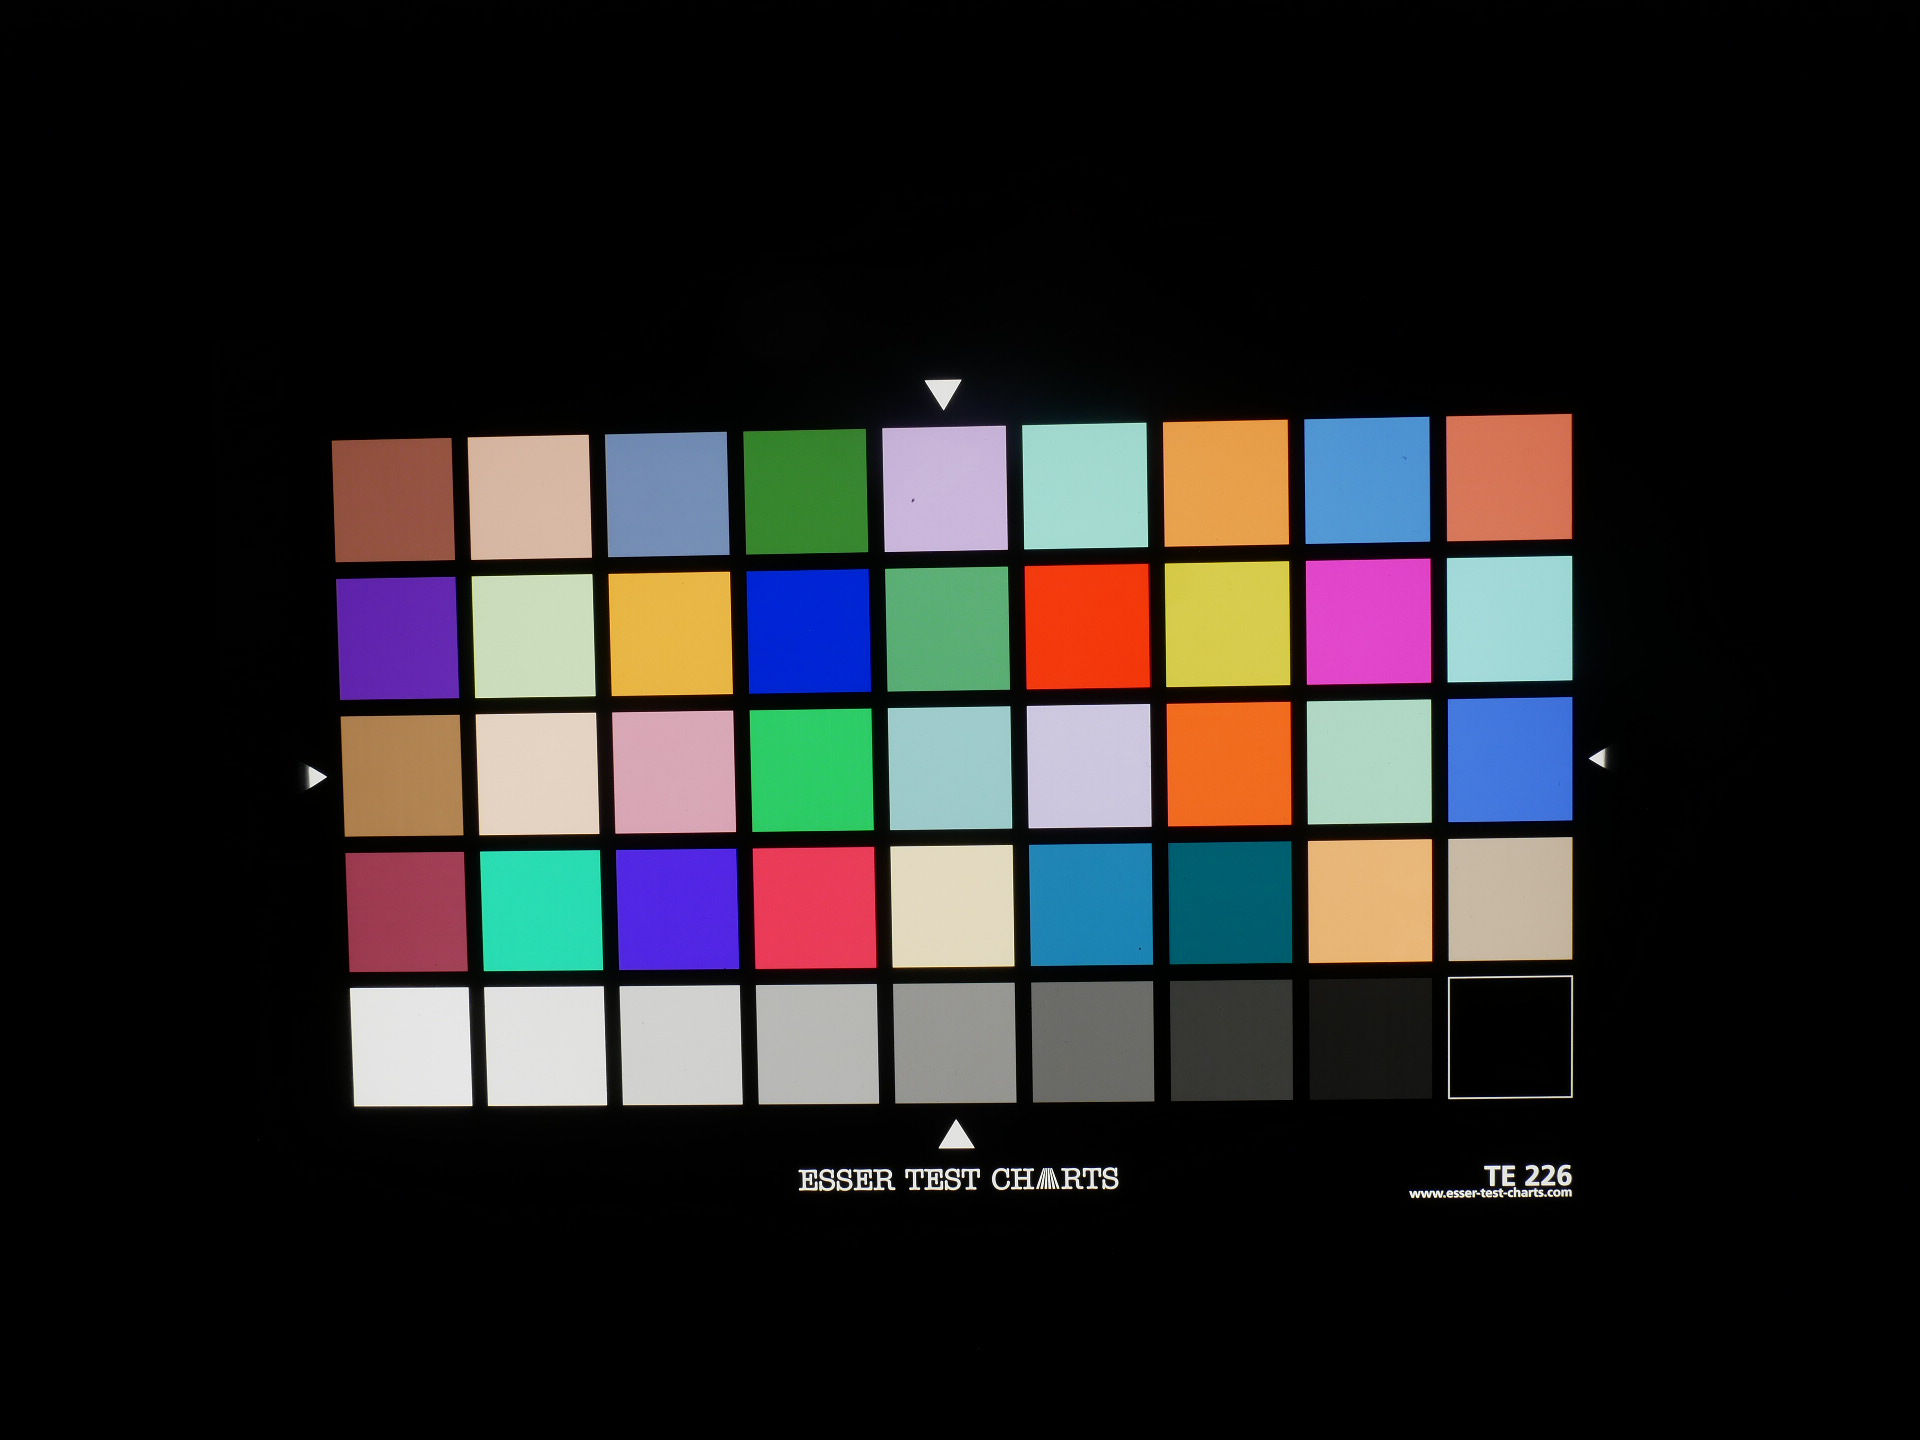

In [2]:
image_path = "data\digital\P1480487.RW2"
raw_image = "" # todo store in image object
thumb = ""
processed = ""
raw_colors = ""
black_level = ""
white_level = ""
with rawpy.imread(image_path) as raw:
    raw_image = raw.raw_image_visible.copy()
    print(f"type: {raw.raw_type}")
    print(f"pattern: {raw.raw_pattern}: {raw.color_desc}")
    black_level = raw.black_level_per_channel[0]
    white_level = raw.camera_white_level_per_channel[0]
    print(f"black: {black_level}")
    print(f"white: {white_level}")
    print(f"num colors: {raw.num_colors}")
    thumb = raw.extract_thumb().data
    processed = raw.postprocess()
    raw_colors = raw.raw_colors
    display(Image.open(io.BytesIO(thumb)))
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


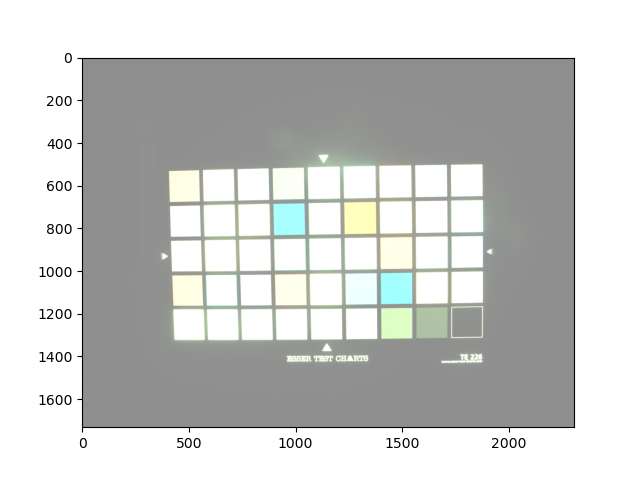

In [3]:
def demosaic(image):
    """
    Converts a raw sensor dump into a 3-tensor of RGB pixel values 
    """
    # todo better demosaic algo
    # todo swap to rawpy postprocess to just export 12 bit tiff with just demosaicing
    # use every second line, starting at line 0, and every second pixel, starting at pixel 0
    blue = image[::2, ::2]
    # use every second line, starting at line 0, and every second pixel, starting at pixel 1
    green = image[::2, 1::2]
    # use every second line, starting at line 1, and every second pixel, starting at pixel 1
    red = image[1::2, 1::2]
    # stack into a 3-tensor
    return np.dstack((red, green, blue))

demosaiced = demosaic(raw_image)
fig1 = plt.figure()
plt.imshow(demosaiced)

In [4]:
def fix_intensity_range(image: np.ndarray, black_level: int, white_level: int):
    """
    maps an array of voltage levels from sensor in RGB pixels to correct color intensity as given by sensor black and white level
    :param image: 3D array (NxMxRGB) of voltage levels for RGB sensor 
    :param black_level: voltage readout for black, assuming identical level per pixel
    :param white_level: voltage readout for white, assuming identical level per pixel
    :return: array with adjusted range [black_level; white_level]
    """
    return np.maximum(np.minimum(image, white_level), black_level) - black_level

level_corrected = fix_intensity_range(demosaiced, black_level, white_level)
level_corrected

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 1, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [1, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 1, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 2, 0],
        [0, 0, 0],
        [1, 0, 0],
        ...,
        [0, 0, 0],
        [0, 2, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [1, 0, 1],
        ...,
        [0, 0, 2],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint16)

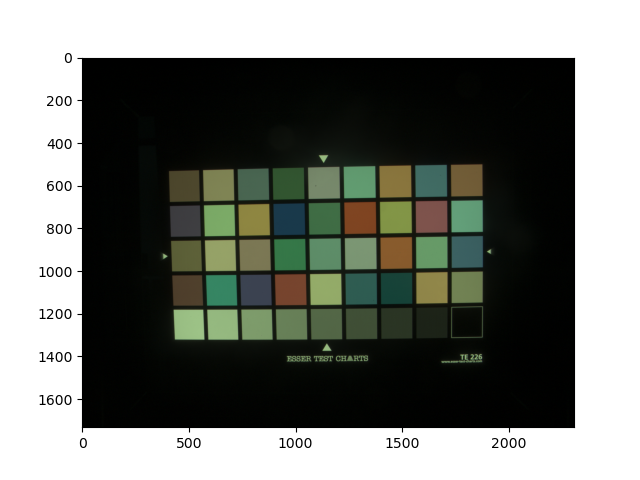

In [51]:
def gamma_correction(image, white_level, gamma=2.2):
    """
    convert image from int [black_level; white_level] scale to float [0, 1] scale with gamma correction
    :param image: 3D numpy array (NxMxRGB) with values between [black_level; white_level]
    :param gamma: gamma to use for gamma correction
    :return: 3D numpy array (NxMxRGB) with values between [0; 1]
    """
    image_0_to_1 = image / white_level
    lower_bounder = np.maximum(image_0_to_1, 0)
    gamma_corrected = np.power(lower_bounder, 1/gamma)
    return np.minimum(gamma_corrected, 1)

corrected = gamma_correction(level_corrected, white_level)
fig3 = plt.figure()
plt.imshow(corrected)

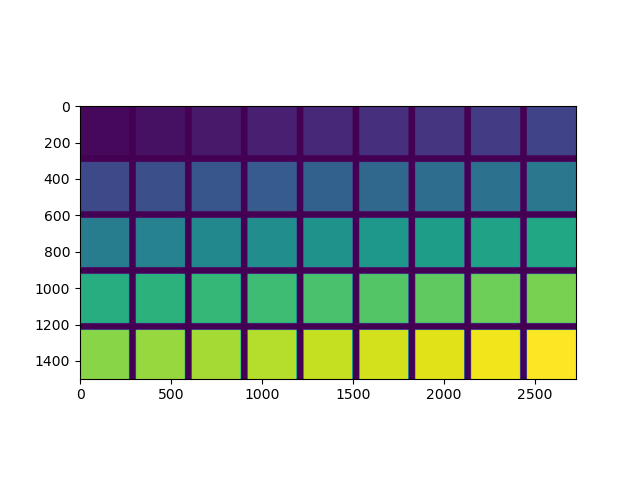

In [6]:
from colorchecker import ColorChecker

plt.close('all')
TE226 = ColorChecker(5, 9, 270, 37)
fig_checker = plt.figure()
plt.imshow(TE226.np_array)

In [7]:
def overlay_color_checker(image: np.ndarray, color_checker: np.ndarray, patch_alpha = 1, non_patch_alpha = 0.5):
    """
    builds an image where the position of the color_checker pattern patches is encoded as the transparency of the image
    :param image: source image on which to overlay the color_checker
    :param color_checker: color checker image to overlay. Needs to be at least as large as image
    :param patch_alpha: transparency value to use when at position of a color checker patch
    :param non_patch_alpha: transparency value to use when not at position of a color checker patch
    :return: a numpy array of 4 value pixels: (R, G, B, A) in range [0,1]
    """
    color_checker = (color_checker[:image.shape[0], :image.shape[1]] >= 1 ) * patch_alpha + (color_checker[:image.shape[0], :image.shape[1]] < 1 ) * non_patch_alpha
    return np.dstack((image, color_checker))


Output()

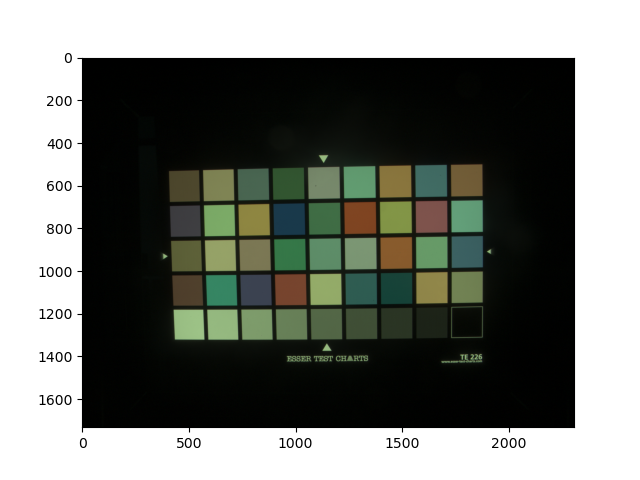

In [8]:
from matplotlib.backend_bases import MouseEvent
from colorchecker import ColorCheckerReadings
import ipywidgets as widgets
import cv2

plt.close('all')

def identify_patches(image, reading: ColorCheckerReadings) -> None:
    """
    Gives a UI interface for the user to correctly identify the color chart on an image
    :param image: image to use for visualization. Does not have to be the same image as for the patch reading, but the colorchart needs to be at the same location on both images. Only acceots images with pixel values in range [0,1]
    :param reading: patch reading
    """
    fig_overlay = plt.figure()
    im_overlay = plt.imshow(image)
    out = widgets.Output()

    @out.capture()
    def onclick(event: MouseEvent):
        button_to_coord_map = {
            (1, None): reading.assign_top_left,
            (3, None): reading.assign_top_right,
            (1, 'shift'): reading.assign_bottom_left,
            (3, 'shift'): reading.assign_bottom_right
        }
        button_to_coord_map[(event.button,event.key)](event.xdata, event.ydata)
            
        if reading.patch_location_info is not None:
            im_overlay.set_data(overlay_color_checker(image, reading.patch_location_info))
            fig_overlay.canvas.draw_idle()
            
    display(out)
    cid = fig_overlay.canvas.mpl_connect('button_press_event', onclick)
    
TE226_g81_reading = ColorCheckerReadings(TE226, level_corrected)
identify_patches(corrected, TE226_g81_reading)

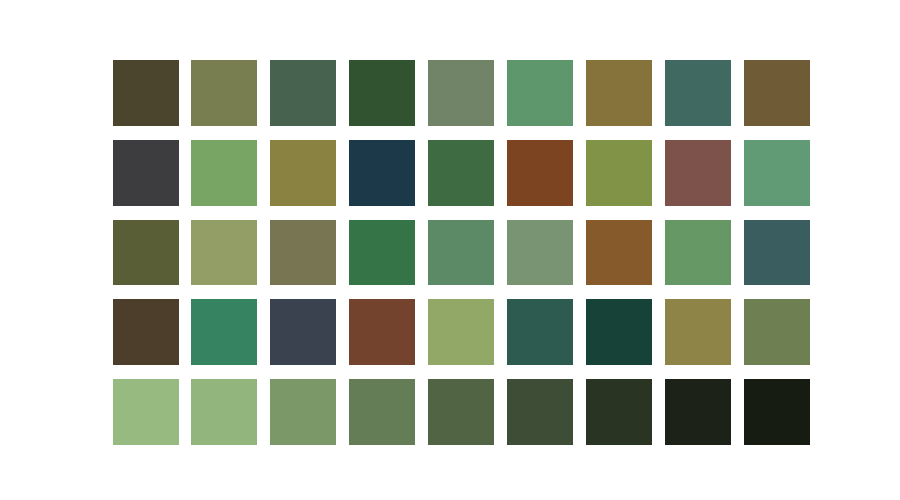

In [18]:
def plot_patches(reading: ColorCheckerReadings, white_level: int = None):
    """
    plot the patch readings of a color chart
    :param reading: the ColorCheckerReading object which needs to have already extracted the patch data
    :param white_level: (optional) white level to use if we want to apply an inv_gamma correction (conversion to [0,1] range) on the image
        if none is provided, the plot will use the raw patch data values (image data has to conform to [0,255] or [0,1])
    """
    assert reading.patch_data is not None
    plt.figure(figsize=(reading.color_checker.num_cols, reading.color_checker.num_rows))
    for i in range(reading.color_checker.num_rows):
        for j in range(reading.color_checker.num_cols):
            plt.subplot(reading.color_checker.num_rows, reading.color_checker.num_cols, i*reading.color_checker.num_cols+j+1)
            if white_level is not None:
                plt.imshow(
                    gamma_correction(
                        reading.patch_data[
                            np.newaxis, np.newaxis, i*reading.color_checker.num_cols+j
                        ], white_level
                    )
                )
            else:
                plt.imshow(
                    reading.patch_data[
                        np.newaxis, np.newaxis, i*reading.color_checker.num_cols+j
                    ].astype(int)
                )
            plt.axis('off')

plot_patches(TE226_g81_reading, white_level)

# TIF processing pipeline

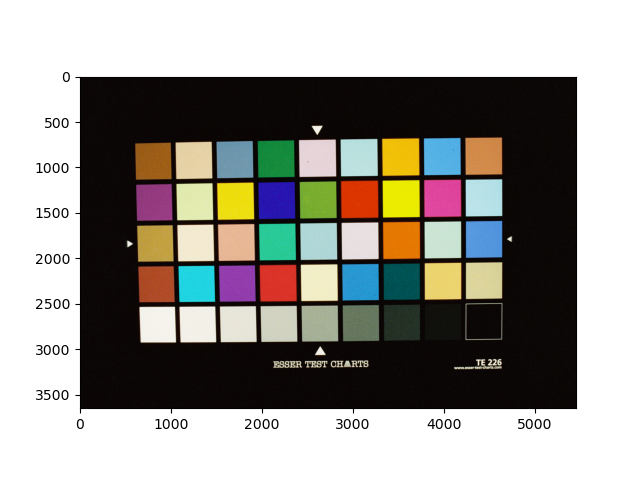

In [44]:
tif = Image.open("data/film/A002382raphael-R1-20-21.TIF")
tif_array = np.array(tif)
plt.figure()
plt.imshow(tif_array)

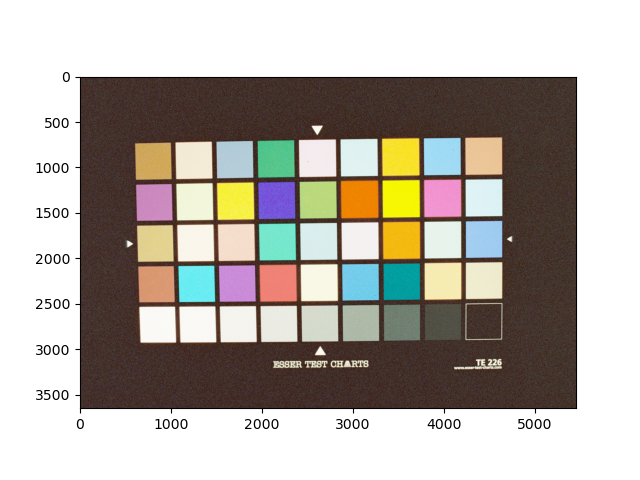

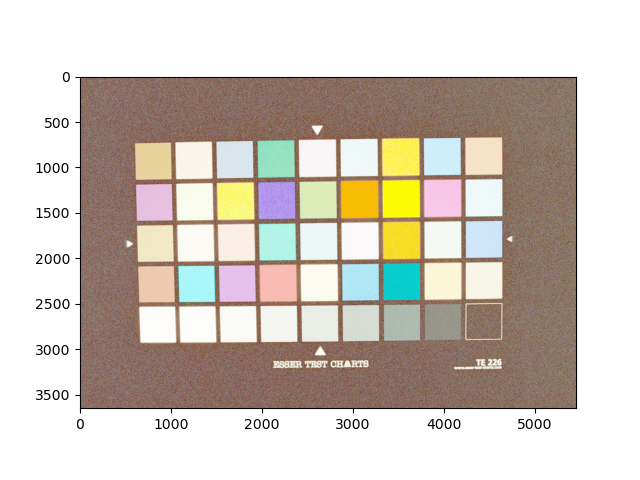

In [47]:
# inverse gamma correction
inv_gamma = gamma_correction(tif_array, white_level=255, gamma=2.4)
plt.figure()
plt.imshow(inv_gamma)

Output()

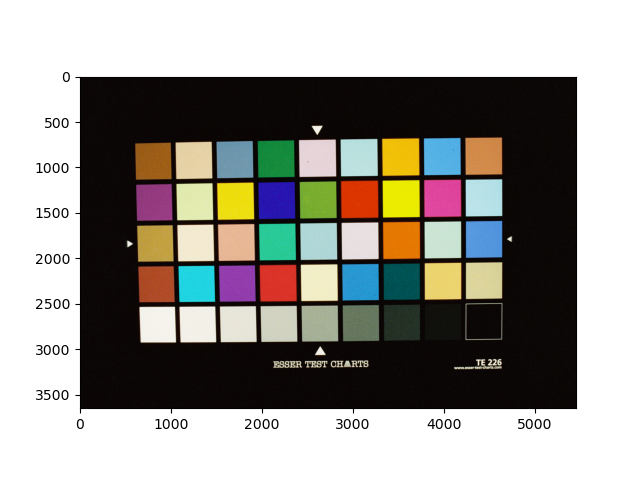

In [53]:
TE226_800t_reading = ColorCheckerReadings(TE226, inv_gamma)
identify_patches(tif_array/255, TE226_800t_reading)

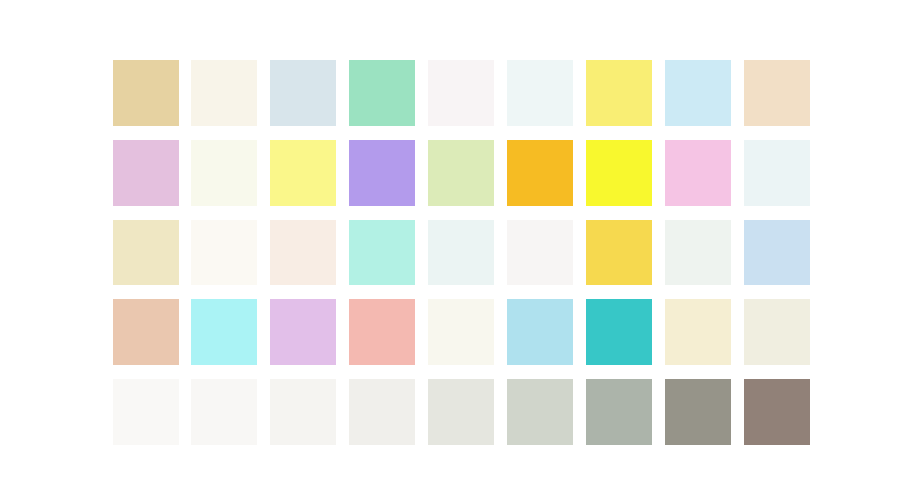

In [58]:
plot_patches(TE226_800t_reading, white_level=1)

In [59]:
zeroes = np.zeros((45,3))
patches_camera = TE226_g81_reading.patch_data
A = np.concatenate((
    np.concatenate((patches_camera, zeroes, zeroes), axis = 1),
    np.concatenate((zeroes, patches_camera, zeroes), axis = 1),
    np.concatenate((zeroes, zeroes, patches_camera), axis = 1),
))
target = np.ravel(TE226_800t_reading.patch_data.T)
A.shape

(135, 9)

In [60]:
import scipy.linalg as la

q,r = la.qr(A, mode='economic')
color_matrix_vector = la.solve_triangular(r, q.T @ target)
color_matrix_vector

array([ 9.65143721e-04, -3.79689396e-04,  1.21707398e-03,  4.48495365e-04,
        9.93432127e-05,  9.32022099e-04,  2.08621022e-04, -4.18346895e-04,
        2.27100514e-03])

C:\Users\Shanzhaii\AppData\Local\Temp\ipykernel_19224\1391327729.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


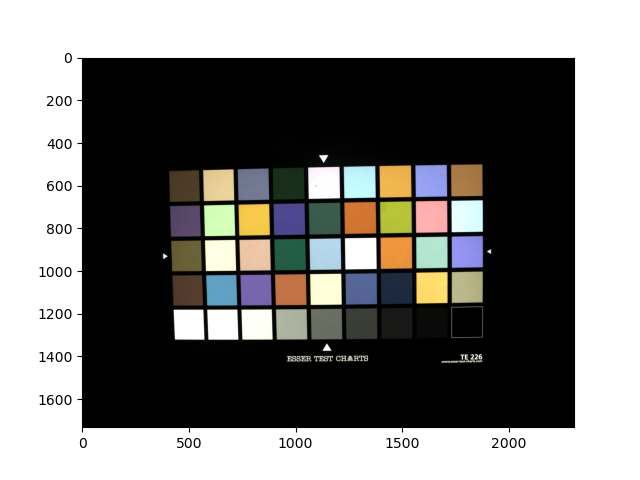

In [61]:
color_matrix = np.reshape(color_matrix_vector, (3,3))
plt.figure()
plt.imshow((level_corrected@color_matrix.T))

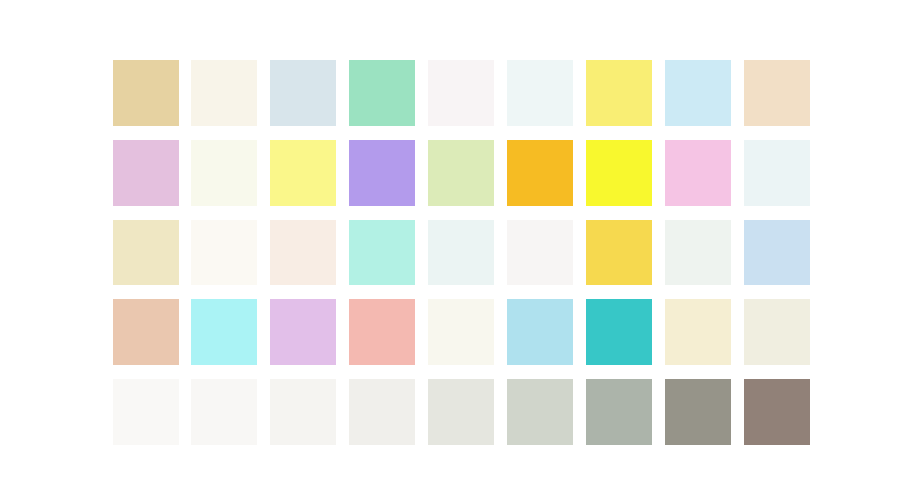

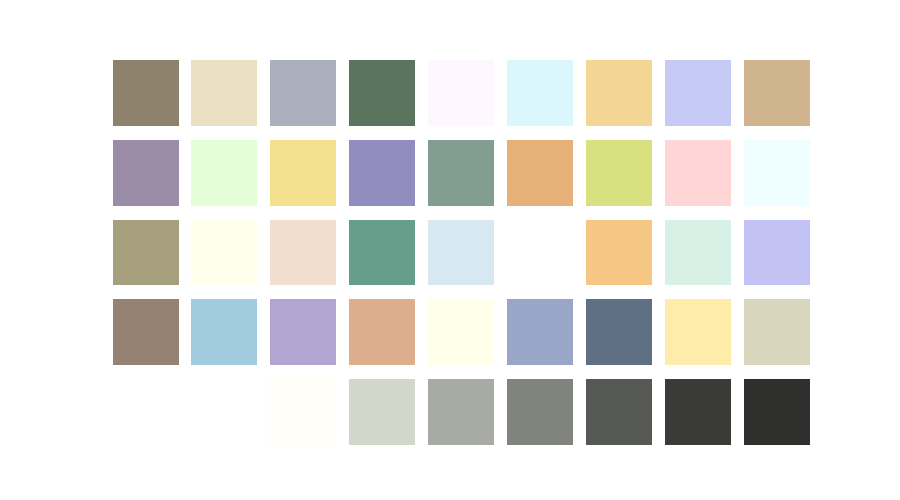

In [63]:
plt.close('all')
plot_patches(TE226_800t_reading, 1)
TE226_G81_updated_readings = ColorCheckerReadings(TE226,None, patch_data=np.minimum(TE226_g81_reading.patch_data@color_matrix.T, 255))
plot_patches(TE226_G81_updated_readings, 1)

# Failed tests

In [ ]:
import cv2

In [ ]:
# test 1: square detection
# Load image, grayscale, and Otsu's threshold
nparr = np.asarray(bytearray(thumb), dtype="uint8")
image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
thresh = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY )[1]

# thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

# Find contours
cnts, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Filter for rectangles and squares
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.04 * peri, True)
    if len(approx) == 4:
        cv2.drawContours(image, [approx], -1, (0, 255, 0), 3)
# Display the image
cv2.imshow('Detected Rectangles and Squares', image)
cv2.waitKey(0)

In [ ]:
# test 2: Hough line transform
# Load image, grayscale, Canny edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
# Use HoughLinesP to detect lines
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)
# Draw lines on the image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
# Display the image
cv2.imshow('Hough Lines', image)
cv2.waitKey(0)